# Сборный проект - 1: Определение закономерностей успешности игр.

Описание проекта: Интернет-магазин продаёт компьютерные игры по всему миру. Из открытых источников доступны исторические данные о продажах игр, оценках пользователей и экспертов, жанры и игровые платформы (Xbox или PlayStation и другие). Необходимо выявить закономерности, которые определяют "успешность" игр, что позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.
Имеются данные до 2016 года. В целях анализа, представим, что сейчас декабрь 2016 г., и мы планируем кампанию на следующий - 2017-й год.

## Открытие файла с данными, изучение общей информации

### Загрузка библиотек и вывод данных

In [1]:
# загрузим необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import warnings
warnings.filterwarnings('ignore')

try:
    df = pd.read_csv('games.csv')
except:
    print('Ошибка выгрузки данных')

df.head(5)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Отдельно выведем на экран уникальные значения некоторых столбцов для первичного анализа и обработки.

#### Игровые платформы и производители

In [3]:
print(df['Platform'].sort_values().unique())
print('')
print('Кол-во уникальных значений игровых платформ:', df['Platform'].nunique())

['2600' '3DO' '3DS' 'DC' 'DS' 'GB' 'GBA' 'GC' 'GEN' 'GG' 'N64' 'NES' 'NG'
 'PC' 'PCFX' 'PS' 'PS2' 'PS3' 'PS4' 'PSP' 'PSV' 'SAT' 'SCD' 'SNES' 'TG16'
 'WS' 'Wii' 'WiiU' 'X360' 'XB' 'XOne']

Кол-во уникальных значений игровых платформ: 31


In [4]:
df['Platform'].value_counts().head(10) # выведем на экран самые популярные платформы

PS2     2161
DS      2151
PS3     1331
Wii     1320
X360    1262
PSP     1209
PS      1197
PC       974
XB       824
GBA      822
Name: Platform, dtype: int64

In [5]:
df['Platform'] = df['Platform'].replace('X360', 'Xbox 360') # некоторые платформы приведем к более привычным названиям
df['Platform'] = df['Platform'].replace('XB', 'Xbox')
df['Platform'] = df['Platform'].replace('XOne', 'Xbox One')

In [6]:
df['Platform'].value_counts().head()

PS2         2161
DS          2151
PS3         1331
Wii         1320
Xbox 360    1262
Name: Platform, dtype: int64

In [7]:
# создадим функцию которая поможет добавить производителя к платформе
# данные из открытых источников.
def manufactured_by(platform): 
    if platform in ['PS2', 'PS3', 'PS4', 'PSV', 'PSP', 'PS']:
        return 'Sony (Japan)'
    if platform in ['DS', 'Wii', 'GBA', 'GC', '3DS', 'WiiU', 'NES', 'GB', 'SNES', 'N64']:
        return 'Nintendo (Japan)'
    if platform in ['Xbox 360', 'Xbox', 'Xbox One']:
        return 'Microsoft (USA)'
    if platform == 'PC':
        return 'Personal computer'
    if platform == '2600':
        return 'Atary (Japan)'
    return 'Other'

df['manufacturer'] = df['Platform'].apply(manufactured_by) # методом apply() добавим производителя в таблицу.

In [8]:
df['manufacturer'].value_counts()

Sony (Japan)         6720
Nintendo (Japan)     6270
Microsoft (USA)      2333
Personal computer     974
Other                 285
Atary (Japan)         133
Name: manufacturer, dtype: int64

Основные производители игровых платформ это: Sony, Nintendo и Microsoft. На четвертом месте идут игры выпущенные на ПК.

In [9]:
other = df.query('manufacturer == "Other"')
other['Platform'].value_counts()

SAT     173
DC       52
GEN      29
NG       12
WS        6
SCD       6
3DO       3
TG16      2
GG        1
PCFX      1
Name: Platform, dtype: int64

Доля других производителей не велика.

#### Жанры

In [10]:
print(df['Genre'].sort_values().unique())
print('')
print('Кол-во уникальных значений игровых жанров:', df['Genre'].nunique())

['Action' 'Adventure' 'Fighting' 'Misc' 'Platform' 'Puzzle' 'Racing'
 'Role-Playing' 'Shooter' 'Simulation' 'Sports' 'Strategy' nan]

Кол-во уникальных значений игровых жанров: 12


In [11]:
df['Genre'] = df['Genre'].str.lower()

In [12]:
df['Genre'].value_counts()

action          3369
sports          2348
misc            1750
role-playing    1498
shooter         1323
adventure       1303
racing          1249
platform         888
simulation       873
fighting         849
strategy         683
puzzle           580
Name: Genre, dtype: int64

#### Рейтинг игр ESRB

Entertainment Software Rating Board (ESRB) — негосударственная организация, основное направление деятельности — принятие и определение рейтингов для компьютерных видеоигр и другого развлекательного программного обеспечения в США и Канаде.

[Ссылка на информацию о рейтинге ESRB](https://ru.wikipedia.org/wiki/Entertainment_Software_Rating_Board#%D0%A3%D1%81%D1%82%D0%B0%D1%80%D0%B5%D0%B2%D1%88%D0%B8%D0%B5)

Сделаем вывод информации о рейтингах игр:

In [13]:
df['Rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

In [14]:
df['Rating'].value_counts()

E       3990
T       2961
M       1563
E10+    1420
EC         8
RP         3
K-A        3
AO         1
Name: Rating, dtype: int64

Отсутствует информация о рейтинге 83 игр (unknown). В основном всем играм присвоены следующие значения рейтинга: Т - Teen: подросткам, E - Everyone: для всех, M - Mature: для взрослых (17+) и Е10+ - Everyone 10 and older: для всех от 10 лет и старше.

«RP» («Rating Pending») — «Рейтинг ожидается»: Продукт был отправлен в ESRB и ожидает присвоения рейтинга.

Все полученные рейтинги действующие, за исключением: K-A - игры для детей (в 1998 году этот рейтинг был переименован в E); EC Для детей младшего возраста - в дальнейшем был включен в рейтинг E). Рейтинг К-А и EC переименуем в Е.

Посмотрим на игры с рейтингом AO (Adults Only(18+)) и RP:

In [15]:
df.query('Rating == ["AO", "RP"]')

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating,manufacturer
875,Grand Theft Auto: San Andreas,Xbox,2005.0,action,1.26,0.61,0.0,0.09,93.0,8.6,AO,Microsoft (USA)
13672,Clockwork Empires,PC,NaN,strategy,0.00,0.04,0.0,0.00,58.0,3.8,RP,Personal computer
14270,Supreme Ruler: Cold War,PC,2011.0,strategy,0.00,0.03,0.0,0.01,63.0,6.8,RP,Personal computer
16180,WRC: FIA World Rally Championship,PC,NaN,racing,0.00,0.01,0.0,0.00,65.0,NaN,RP,Personal computer


In [16]:
df.query('Name == "Grand Theft Auto: San Andreas"')

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating,manufacturer
17,Grand Theft Auto: San Andreas,PS2,2004.0,action,9.43,0.40,0.41,10.57,95.0,9,M,Sony (Japan)
875,Grand Theft Auto: San Andreas,Xbox,2005.0,action,1.26,0.61,0.00,0.09,93.0,8.6,AO,Microsoft (USA)
2115,Grand Theft Auto: San Andreas,PC,2005.0,action,0.00,0.93,0.00,0.04,93.0,8.9,M,Personal computer
10311,Grand Theft Auto: San Andreas,Xbox 360,2008.0,action,0.08,0.02,0.00,0.01,NaN,7.5,M,Microsoft (USA)


In [17]:
df.query('Name == "Clockwork Empires"')

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating,manufacturer
13672,Clockwork Empires,PC,NaN,strategy,0.0,0.04,0.0,0.0,58.0,3.8,RP,Personal computer


Игра Grand Theft Auto: San Andreas первоначально имела рейтинг AO, который в дальнейшем был заменен на M при переиздании игры. В срезе по этой игре на других платформах также везде указан рейтинг М. Заменим рейтинг на М. Строки с играми Clockwork Empires и WRC: FIA World Rally Championship отфильтруем в дальнейшем, т.к. нет данных по году выхода этих игр. Supreme Ruler: Cold War	на сайте ESRB имеет рейтинг Е, в дальнейшем его переименуем текущий рейтинг игры на Е.

In [18]:
# замена значений рейтингов
df['Rating'] = df['Rating'].replace('AO', 'M')
df['Rating'] = df['Rating'].replace('K-A', 'E')
df['Rating'] = df['Rating'].replace('EC', 'E')

In [19]:
df.query('Name == "Grand Theft Auto: San Andreas"')

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating,manufacturer
17,Grand Theft Auto: San Andreas,PS2,2004.0,action,9.43,0.40,0.41,10.57,95.0,9,M,Sony (Japan)
875,Grand Theft Auto: San Andreas,Xbox,2005.0,action,1.26,0.61,0.00,0.09,93.0,8.6,M,Microsoft (USA)
2115,Grand Theft Auto: San Andreas,PC,2005.0,action,0.00,0.93,0.00,0.04,93.0,8.9,M,Personal computer
10311,Grand Theft Auto: San Andreas,Xbox 360,2008.0,action,0.08,0.02,0.00,0.01,NaN,7.5,M,Microsoft (USA)


In [20]:
df['Rating'].value_counts()

E       4001
T       2961
M       1564
E10+    1420
RP         3
Name: Rating, dtype: int64

### Проверка на пропуски и дубликаты

In [21]:
df.duplicated().sum() # проверим наличие явных дубликатов

0

In [22]:
df.isna().sum() # проверка на кол-во пропусков

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
NA_sales              0
EU_sales              0
JP_sales              0
Other_sales           0
Critic_Score       8578
User_Score         6701
Rating             6766
manufacturer          0
dtype: int64

In [23]:
pd.DataFrame(round((df.isna().mean()*100),1)).style.background_gradient('coolwarm')

,0
Name,0.000000
Platform,0.000000
Year_of_Release,1.600000
Genre,0.000000
NA_sales,0.000000
EU_sales,0.000000
JP_sales,0.000000
Other_sales,0.000000
Critic_Score,51.300000
User_Score,40.100000


**Описание данных:**
•	Name — название игры

•	Platform — платформа

•	Year_of_Release — год выпуска

•	Genre — жанр игры

•	NA_sales — продажи в Северной Америке (миллионы проданных копий)

•	EU_sales — продажи в Европе (миллионы проданных копий)

•	JP_sales — продажи в Японии (миллионы проданных копий)

•	Other_sales — продажи в других странах (миллионы проданных копий)

•	Critic_Score — оценка критиков (максимум 100)

•	User_Score — оценка пользователей (максимум 10)

•	Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

Данные за 2016 год могут быть неполными.


**Выводы:**

В таблице 16715 строк. 

Названия столбцов необходимо привести к нижнему регистру.

Данные в столбце Year_of_Release необходимо привести в целочисленное значение, а в столбце User_Score из текстового типа данных в вещественный.

Явные дубликаты отсутствуют.

В таблице присутствуют пропуски. Наибольшее количество данных пропущено в столбце Critic_Score - 51.3%, также очень большой процент пропусков в User_Score - 40.1% и Rating - 40.5%. Есть пропуски и в годе выпуска игр - 1.6% (Year_of_Release).

## Подготовка данных

•	Замените названия столбцов (приведите к нижнему регистру);
•	Преобразуйте данные в нужные типы. Опишите, в каких столбцах заменили тип данных и почему;
•	Обработайте пропуски при необходимости:
o	Объясните, почему заполнили пропуски определённым образом или почему не стали это делать;
o	Опишите причины, которые могли привести к пропускам;
o	Обратите внимание на аббревиатуру 'tbd' в столбце с оценкой пользователей. Отдельно разберите это значение и опишите, как его обработать;
•	Посчитайте суммарные продажи во всех регионах и запишите их в отдельный столбец.

### Замена названий столбцов

In [24]:
df.columns = df.columns.str.lower() # приведем все названия столбцов в нижний регистр
df.head(0)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,manufacturer


### Работа с пропусками

#### Столбец name

In [25]:
df[df.name.isna()] # выведем строки с пропущенными данными о названии игр

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,manufacturer
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN,Other
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN,Other


In [26]:
# релиз игр с пропущенными названиями состоялся более 20 лет назад,
# также в строках нет информации о жанре, оценках критиков и пользователей.
# этими данными можно пренебречь.
print('Кол-во строк до удаления:', len(df))
df.dropna(subset=['name'], inplace=True)
print('Кол-во строк после удаления:', len(df))

Кол-во строк до удаления: 16715
Кол-во строк после удаления: 16713


#### Столбец year_of_release

In [27]:
# кол-во пропусков в year_of_release 269 (доля 1.6%), отфильтруем таблицу, исключив эти данные:
#df = df[df.columns[~df.isnull().all()]]
print('Кол-во строк до фильтрации:', len(df))
df = df[~df['year_of_release'].isna()]
print('Кол-во строк после фильтрации:', len(df))

Кол-во строк до фильтрации: 16713
Кол-во строк после фильтрации: 16444


#### Столбец rating

In [28]:
# пропусков в рейтинге слишком много.Удаление пропусков или их замена на медианные значения сильно повлияет на итоговый результат.
# заменим пропуски на unknown.
df['rating'] = df['rating'].fillna('unknown')

#### Столбец user_score

In [29]:
df['user_score'].sort_values().unique() # посмотрим на имеющиеся значения в user_score:

array(['0', '0.2', '0.3', '0.5', '0.6', '0.7', '0.9', '1', '1.1', '1.2',
       '1.3', '1.4', '1.5', '1.6', '1.7', '1.8', '1.9', '2', '2.1', '2.2',
       '2.3', '2.4', '2.5', '2.6', '2.7', '2.8', '2.9', '3', '3.1', '3.2',
       '3.3', '3.4', '3.5', '3.6', '3.7', '3.8', '3.9', '4', '4.1', '4.2',
       '4.3', '4.4', '4.5', '4.6', '4.7', '4.8', '4.9', '5', '5.1', '5.2',
       '5.3', '5.4', '5.5', '5.6', '5.7', '5.8', '5.9', '6', '6.1', '6.2',
       '6.3', '6.4', '6.5', '6.6', '6.7', '6.8', '6.9', '7', '7.1', '7.2',
       '7.3', '7.4', '7.5', '7.6', '7.7', '7.8', '7.9', '8', '8.1', '8.2',
       '8.3', '8.4', '8.5', '8.6', '8.7', '8.8', '8.9', '9', '9.1', '9.2',
       '9.3', '9.4', '9.5', '9.6', '9.7', 'tbd', nan], dtype=object)

In [30]:
df['user_score'].value_counts()

tbd    2376
7.8     322
8       285
8.2     276
8.3     252
       ... 
1.3       2
1.9       2
0.5       2
9.7       1
0         1
Name: user_score, Length: 96, dtype: int64

In [31]:
# большая часть данных (2376 значений) в user_score имеет значение tbd - to be defined (предстоит определить).
# заменим эти пропуски на nan:
print('Количество nan до обработки:', df['user_score'].isna().sum())
df.loc[df['user_score'] == 'tbd', 'user_score'] = float('nan')
print('Количество nan после обработки:', df['user_score'].isna().sum())

Количество nan до обработки: 6605
Количество nan после обработки: 8981


#### Столбец critic_score

In [32]:
df['critic_score'].sort_values().unique()

array([13., 17., 19., 20., 21., 23., 24., 25., 26., 27., 28., 29., 30.,
       31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41., 42., 43.,
       44., 45., 46., 47., 48., 49., 50., 51., 52., 53., 54., 55., 56.,
       57., 58., 59., 60., 61., 62., 63., 64., 65., 66., 67., 68., 69.,
       70., 71., 72., 73., 74., 75., 76., 77., 78., 79., 80., 81., 82.,
       83., 84., 85., 86., 87., 88., 89., 90., 91., 92., 93., 94., 95.,
       96., 97., 98., nan])

Значения tbd в critic_score отсутствуют. Количество nan в critic_score слишком большое, чтобы заменять его на среднее или медиану, т.к. это приведет к искажениям в итоговых выводах. Оставим эти значения без изменений.

In [33]:
df['critic_score'].nunique()

81

#### Столбец genre

In [34]:
# в столбце жанр ранее были пропуски, выведем эти строки на экран
df[df.genre.isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,manufacturer


Пропуски отсутствуют, эти игры были отфильтрованы ранее.

In [35]:
df.isna().sum() # финальная проверка на кол-во пропусков

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8461
user_score         8981
rating                0
manufacturer          0
dtype: int64

### Преобразование типов данных

In [36]:
# строки с отсутсвующими значениями в year_of_release отфильтрованы, заменим тип данный на целочисленный
df['year_of_release'] = df['year_of_release'].astype(int)

In [37]:
# изменим тип данных в столбце user_score из текстового в вещественный:
# в парамете errors указываем errors='coerce', для того, чтобы все некорректные значения принудительно заменились на NaN;
df['user_score'] = pd.to_numeric(df['user_score'], errors='coerce')

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int32  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       7463 non-null   float64
 10  rating           16444 non-null  object 
 11  manufacturer     16444 non-null  object 
dtypes: float64(6), int32(1), object(5)
memory usage: 1.6+ MB


Тип данных в year_of_release заменен на int64, тип данных в user_score заменен на float64.

### Финальные преобразования

По итогам всех преобразований заменим рейтинг RP в игре Supreme Ruler: Cold War на E.

In [39]:
df.query('name == "Supreme Ruler: Cold War"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,manufacturer
14270,Supreme Ruler: Cold War,PC,2011,strategy,0.0,0.03,0.0,0.01,63.0,6.8,RP,Personal computer


In [40]:
df['rating'] = df['rating'].replace('RP', 'E')

In [41]:
df.query('name == "Supreme Ruler: Cold War"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,manufacturer
14270,Supreme Ruler: Cold War,PC,2011,strategy,0.0,0.03,0.0,0.01,63.0,6.8,E,Personal computer


In [42]:
df['rating'].value_counts()

unknown    6676
E          3933
T          2905
M          1537
E10+       1393
Name: rating, dtype: int64

### Расчет суммарных продаж по всем регионам

In [43]:
# создадим столбец total_sales и внесем туда рез-ты продаж по всем регионам
df['total_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']

# сделаем вывод финальной таблицы по итогам подготовки данных:
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,manufacturer,total_sales
0,Wii Sports,Wii,2006,sports,41.36,28.96,3.77,8.45,76.0,8.0,E,Nintendo (Japan),82.54
1,Super Mario Bros.,NES,1985,platform,29.08,3.58,6.81,0.77,NaN,NaN,unknown,Nintendo (Japan),40.24
2,Mario Kart Wii,Wii,2008,racing,15.68,12.76,3.79,3.29,82.0,8.3,E,Nintendo (Japan),35.52
3,Wii Sports Resort,Wii,2009,sports,15.61,10.93,3.28,2.95,80.0,8.0,E,Nintendo (Japan),32.77
4,Pokemon Red/Pokemon Blue,GB,1996,role-playing,11.27,8.89,10.22,1.00,NaN,NaN,unknown,Nintendo (Japan),31.38


In [44]:
print('Количество строк в финальной таблице:', len(df))

Количество строк в финальной таблице: 16444


## Исследовательский анализ данных

•	Посмотрите, сколько игр выпускалось в разные годы. Важны ли данные за все периоды?

•	Посмотрите, как менялись продажи по платформам. Выберите платформы с наибольшими суммарными продажами и постройте распределение по годам. За какой характерный срок появляются новые и исчезают старые платформы?

•	Возьмите данные за соответствующий актуальный период. Актуальный период определите самостоятельно в результате исследования предыдущих вопросов. Основной фактор — эти данные помогут построить прогноз на 2017 год.

•	Не учитывайте в работе данные за предыдущие годы.

•	Какие платформы лидируют по продажам, растут или падают? Выберите несколько потенциально прибыльных платформ.

•	Постройте график «ящик с усами» по глобальным продажам игр в разбивке по платформам. Опишите результат.

•	Посмотрите, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Постройте диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами. Сформулируйте выводы.

•	Соотнесите выводы с продажами игр на других платформах.

•	Посмотрите на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

### Выпуск игр по годам

In [45]:
# сгруппируем данные по количеству выпущенных игр по годам
year_grouped = df.groupby('year_of_release').agg({'name' : 'count'}).sort_values('year_of_release', ascending=False)
year_grouped.rename(columns={'name': 'count_of_games'}, inplace=True)
year_grouped

,count_of_games
year_of_release,
2016,502
2015,606
2014,581
2013,544
2012,653
2011,1136
2010,1255
2009,1426
2008,1427


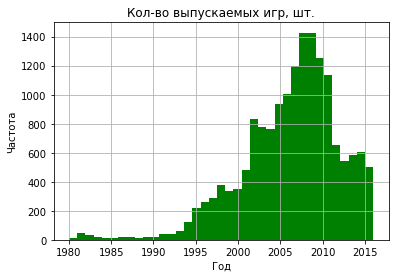

In [46]:
# построим гистограмму
df['year_of_release'].hist(bins=(df['year_of_release'].nunique()), color="g")
plt.title('Кол-во выпускаемых игр, шт.')
plt.xlabel('Год')
plt.ylabel('Частота')
plt.show()

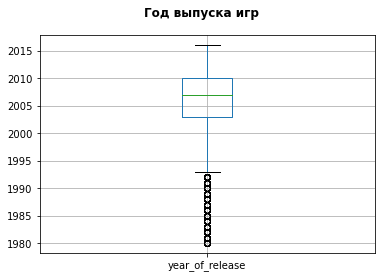

In [47]:
# посмотрим на диаграмму размаха
df.boxplot('year_of_release');
plt.suptitle('Год выпуска игр', fontsize=12, fontweight='bold');

In [48]:
df['year_of_release'].describe().round()

count    16444.0
mean      2006.0
std          6.0
min       1980.0
25%       2003.0
50%       2007.0
75%       2010.0
max       2016.0
Name: year_of_release, dtype: float64

Количество игр, выпущенных до 1993 года включительно, не превышало 100 игр в год. Начиная с 1994 года количество выпускаемых игр начинает расти. Пик выпуска игр пришелся на 2008-2009 года (1426-1427 игр в год), далее количество игр 2 года подряд уменьшалось на 150 игр в среднем. В 2012 году произошло резкое падение кол-ва выпускаемых игр относительно 2011 года: со 1136 до 653 шт./год. Данные за 2016 год могут быть неполными, но последние 5 лет количество вырущенных игр составляло в среднем 577 игр.

Гистограмма скошена влево, среднее и медиана отличаются. Ящик с усами показывает выбросы до 1993 года. Данными выбросами следует пребречь, т.к. они достаточно старые относительно последнего года (разница состаляет 23 года), индустрия далеко шагнула вперед, появилось большое кол-во новых жанров.

In [49]:
df = df.query('year_of_release >= 1994')
print(len(df))

16079


### Продажи игр по платформам

•	Посмотрите, как менялись продажи по платформам. Выберите платформы с наибольшими суммарными продажами и постройте распределение по годам. За какой характерный срок появляются новые и исчезают старые платформы?

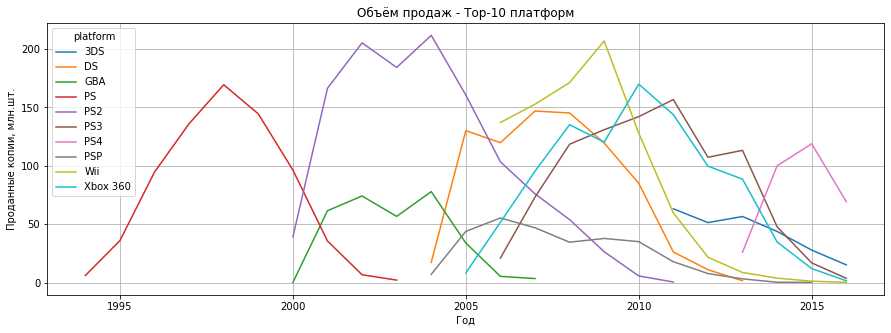

In [50]:
# посмотрим на график продаж игр (total_sales) по самым популярным платформам (топ-10):
platform_sales = df.groupby('platform').agg({'total_sales' : 'sum'}).sort_values('total_sales', ascending=False).head(10).index
df.query('platform in @platform_sales').pivot_table(index='year_of_release', columns='platform',
                                                    values='total_sales', aggfunc='sum').plot(figsize=(15,5), grid=True)
plt.title('Объём продаж - Тор-10 платформ')
plt.xlabel('Год');
plt.ylabel('Проданные копии, млн.шт.');
plt.show()

Для большей наглядности посмотрим на продажи игр только на платформах семейства Sony Playstation (все поколения).

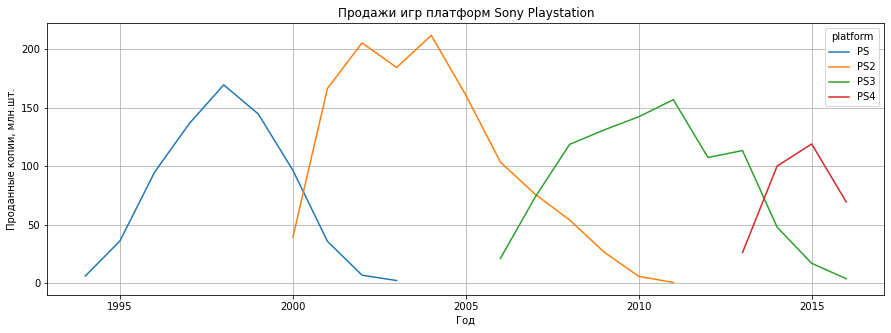

In [51]:
ps_platform = ['PS', 'PS2', 'PS3', 'PS4']
play_station_platform = df.query('platform in @ps_platform')
df.query('platform in @ps_platform').pivot_table(index='year_of_release', columns='platform',
                                                    values='total_sales', aggfunc='sum').plot(figsize=(15,5), grid=True);
plt.title('Продажи игр платформ Sony Playstation')
plt.xlabel('Год');
plt.ylabel('Проданные копии, млн.шт.');
plt.show()

Средний жизненный цикл (активный период) игровой платформы составляет 5-7 лет, рост продаж наблюдается первые 2-3 года с момента выпуска игр для новой платформы, примерно через 10 лет платформа уходит с рынка совсем.

In [52]:
# получим индексы Тор-10 платформ по суммартным продажам
top_10_platform = df.groupby('platform').agg({'total_sales' : 'sum'}).sort_values('total_sales', ascending=False).head(10).index
top_10_platform

Index(['PS2', 'Xbox 360', 'PS3', 'Wii', 'DS', 'PS', 'PS4', 'GBA', 'PSP',
       '3DS'],
      dtype='object', name='platform')

In [53]:
# посмотрим на распределение объёмов продаж по этим платформам:
df.groupby('platform').agg({'total_sales' : 'sum'}).sort_values('total_sales', ascending=False).head(10)

,total_sales
platform,
PS2,1233.56
Xbox 360,961.24
PS3,931.34
Wii,891.18
DS,802.76
PS,727.58
PS4,314.14
GBA,312.88
PSP,289.53


Наибольшие продажи за исследуемый период показали платформы PS2 и Xbox 360: 1233.56 и 961.24 млн.копий игр соответственно.

In [54]:
# сгруппируем данные по платформам и по годам выпуска игр (total_sales), чтобы посмотреть распределение по годам:
actual_period = df.groupby(['platform','year_of_release']).agg({'total_sales': 'sum'}).query('platform in @ top_10_platform and total_sales > 1')
actual_period.head(10)

total_sales
platform year_of_release             
3DS      2011                   63.20
         2012                   51.36
         2013                   56.57
         2014                   43.76
         2015                   27.78
         2016                   15.14
DS       2004                   17.27
         2005                  130.14
         2006                  119.81
         2007                  146.94

### Расчет актуального периода жизни платформы

In [55]:
# рассчитаем средний жизненный период каждой платформы Топ-10:
actual_period = actual_period.reset_index().groupby('platform').agg({'year_of_release' : 'count'})
actual_period.rename(columns={'year_of_release': 'years'}, inplace=True)
actual_period

,years
platform,
3DS,6
DS,10
GBA,7
PS,10
PS2,11
PS3,11
PS4,4
PSP,10
Wii,10


In [56]:
# рассчитаем сколько в среднем живет платформа
actual_period.mean()

years    9.1
dtype: float64

Актуальный период жизни платформы равен 9 годам.

In [57]:
# сделаем срез данных с 2008 года
df_2008 = df.query('year_of_release >= 2008')
print(len(df_2008))

8130


Работать с данными за 9 лет, для планирования продаж и кампаний на ближайший год нет смысла, так как индустрия очень активно меняется, есть смысл сделать срез данных с 2013 года включительно.

In [58]:
# сделаем срез данных с 2013 года для дальнейшего анализа (будем использовать этот фрейм как основной)
df = df.query('year_of_release >= 2013')
print(len(df))

2233


### Какие платформы лидируют по продажам, растут или падают?

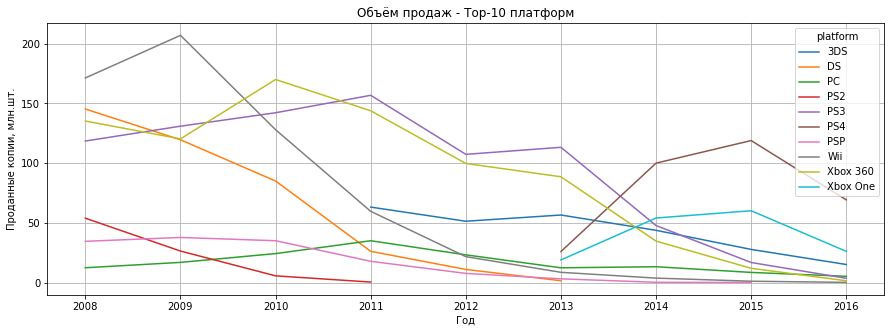

In [59]:
# посмотрим на график продаж игр по самым популярным платформам с 2008 года:
platform_sales = df_2008.groupby('platform').agg({'total_sales' : 'sum'}).sort_values('total_sales', ascending=False).head(10).index
df_2008.query('platform in @platform_sales').pivot_table(index='year_of_release', columns='platform',
                                                    values='total_sales', aggfunc='sum').plot(figsize=(15,5), grid=True)
plt.title('Объём продаж - Тор-10 платформ')
plt.xlabel('Год');
plt.ylabel('Проданные копии, млн.шт.');
plt.show()

За выбранный период на графике четко видно, что с 2008-2010 годов начинается/продолжается снижение объемов продаж практически по всем платформам, в следствии окончания жизненного цикла этих платформ. При этом есть ряд исключений:

Продажи игр для персональных компьютеров (PC) c пиком в 2011 году имеют свою нишу и не имеют какой-либо границы смены платформы. По сути ПК - это платформа вне времени, обновление техники идет своим чередом на постоянной основе. Продажи относительно стабильны за выбранный период.

Игры для платформы 3DS от Nintendo появились только в 2011 году, но кривая продаж стремится вниз. Продажи упали примерно в 2 раза с момента их начала.

В 2013 году крупнейшие производители выпустили свои новые версии приставок: Playstation 4 (PS4) от Sony и Xbox One от Microsoft. Поскольку данные за 2016 год могут быть не полными, однозначно утверждать, что 2015-й год это пик продаж на этих платформах однозначно нельзя. При жизненном цикле 9 лет, следующее поколение приставок выйдет через 6-7 лет (за 2-3 года до окончательного ухода с рынка текущей версии платформы).

Справочно: следующее поколение приставок крупнейших производителей вышло на рынок почти одновременно, в ноябре 2020 года с разницей в несколько дней (PS5 и Xbox Series X/S).

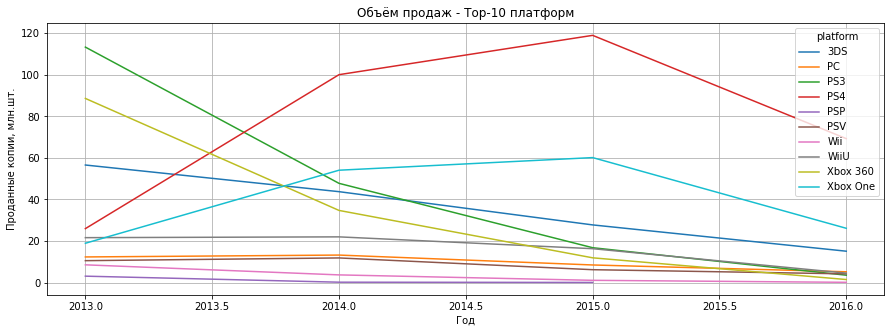

In [60]:
# посмотрим на график продаж игр по самым популярным платформам за выбранный ранее период (с 2013 года):
platform_sales = df.groupby('platform').agg({'total_sales' : 'sum'}).sort_values('total_sales', ascending=False).head(10).index
df.query('platform in @platform_sales').pivot_table(index='year_of_release', columns='platform',
                                                    values='total_sales', aggfunc='sum').plot(figsize=(15,5), grid=True)
plt.title('Объём продаж - Тор-10 платформ')
plt.xlabel('Год');
plt.ylabel('Проданные копии, млн.шт.');
plt.show()

In [61]:
top_10_platform_2013 = df.groupby('platform').agg({'total_sales' : 'sum'}).sort_values('total_sales', ascending=False).head(10).index
top_10_platform_2013 # получаем индексы платформ Тор-10

Index(['PS4', 'PS3', 'Xbox One', '3DS', 'Xbox 360', 'WiiU', 'PC', 'PSV', 'Wii',
       'PSP'],
      dtype='object', name='platform')

Из полученных данных можно сделать следующие выводы:

Самые высокие продажи имеют платформы PS4, PS3 и платформа Xbox One, за исключением платформы PS3 - это актуальные версии платформ от своих производителей.

Платформа 3DS от Nintendo существует уже пять лет, количество проданных копий ежегодно падает, это одна из немногих платформ, которая не показала рост продаж в какой либо из годов относительно предыдущего: постоянное снижение продаж, с небольшим всплеском в 2013 году. Данную платформу нельзя назвать перспективной.

Платформы PS3 и Xbox 360 завершают свой жизненный цикл - это уже не актуальные версии платформ.

Платформа WiiU существует 4 года и не имеет больших перспектив, продажи достаточно скромны.

Отдельную нишу занимают игры, выпущенные на ПК, здесь нет резких взлетов продаж, также как и их стремительного падения.

### Анализ потенциально прибыльных платформ

Самыми потенциальными платформами являются безусловно PS4 и Xbox One, также не будем сбрасывать со счетов PC. Проведем дополнительный анализ по этим платформам.

In [62]:
ps4_platform = df.query('platform == "PS4"')
print(len(ps4_platform))
xbox_one_platform = df.query('platform == "Xbox One"')
print(len(xbox_one_platform))
pc_platform = df.query('platform == "PC"')
print(len(pc_platform))

392
247
189


Игр на PC выходит больше чем, на двух самых популярных приставках вместе взятых.

Построим график «ящик с усами» для этих платформ.

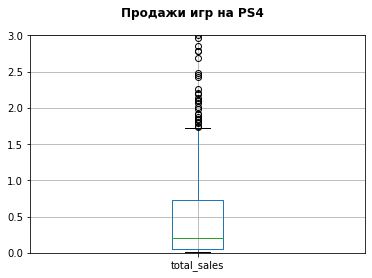

In [63]:
ps4_platform.boxplot('total_sales');
plt.ylim(0, 3)
plt.suptitle('Продажи игр на PS4', fontsize=12, fontweight='bold');

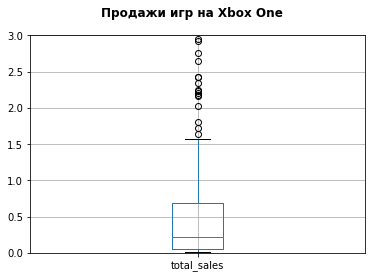

In [64]:
xbox_one_platform.boxplot('total_sales');
plt.ylim(0, 3)
plt.suptitle('Продажи игр на Xbox One', fontsize=12, fontweight='bold');

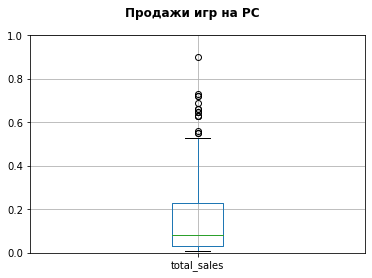

In [65]:
pc_platform.boxplot('total_sales');
plt.ylim(0, 1)
plt.suptitle('Продажи игр на PC', fontsize=12, fontweight='bold');

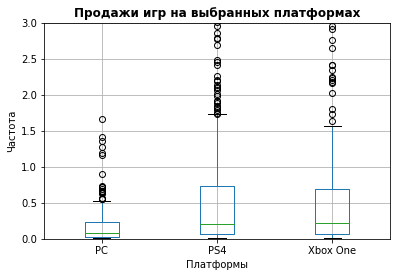

In [66]:
main_platforms = ['PS4', 'Xbox One', 'PC']
df_main = df.query('platform in @main_platforms')
df_main.boxplot('total_sales', by='platform');
plt.ylim(0, 3)
plt.xlabel('Платформы');
plt.ylabel('Частота');
plt.title('Продажи игр на выбранных платформах', fontsize=12, fontweight='bold');
plt.suptitle('');

Все графики показывают большое количество выбросов в верхних границах. По сути эти выбросы формируют игры-хиты продаж, приносящие значительную прибыль разработчикам игр, производителям платформ и т.д. Самые неоднородные данные по продажам имеет приставка PS4, наименьший разброс данных по продажам игр - на PC.

Посмотрим на самые продаваемые игры по платформам:

In [67]:
ps4_platform.head(3)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,manufacturer,total_sales
31,Call of Duty: Black Ops 3,PS4,2015,shooter,6.03,5.86,0.36,2.38,NaN,NaN,unknown,Sony (Japan),14.63
42,Grand Theft Auto V,PS4,2014,action,3.96,6.31,0.38,1.97,97.0,8.3,M,Sony (Japan),12.62
77,FIFA 16,PS4,2015,sports,1.12,6.12,0.06,1.28,82.0,4.3,E,Sony (Japan),8.58


In [68]:
xbox_one_platform.head(3)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,manufacturer,total_sales
99,Call of Duty: Black Ops 3,Xbox One,2015,shooter,4.59,2.11,0.01,0.68,NaN,NaN,unknown,Microsoft (USA),7.39
165,Grand Theft Auto V,Xbox One,2014,action,2.81,2.19,0.00,0.47,97.0,7.9,M,Microsoft (USA),5.47
179,Call of Duty: Advanced Warfare,Xbox One,2014,shooter,3.22,1.55,0.01,0.48,81.0,5.4,M,Microsoft (USA),5.26


In [69]:
pc_platform.head(3)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,manufacturer,total_sales
458,The Sims 4,PC,2014,simulation,1.00,1.82,0.0,0.23,70.0,3.9,T,Personal computer,3.05
1095,StarCraft II: Heart of the Swarm,PC,2013,strategy,0.83,0.66,0.0,0.18,86.0,7.9,T,Personal computer,1.67
1351,SimCity (2013),PC,2013,simulation,0.48,0.77,0.0,0.17,64.0,2.2,E10+,Personal computer,1.42


Игры на приставках идентичны, отличаются только третьим местом. Продажи на Xbox One ниже относительно PS4. Хиты на ПК совершенно другие, как и год выпуска игр: наибольшие продажи на ПК принесли игры в 2009-2012 году, в то время как на приставках это игры 2014-2015 года.

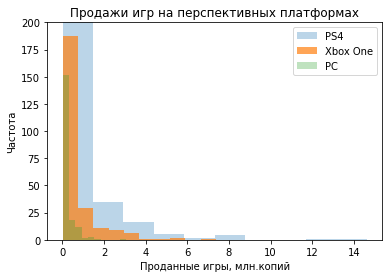

In [70]:
ps4_platform['total_sales'].plot(kind='hist', alpha=0.3, label='PS4', bins=10)
xbox_one_platform['total_sales'].plot(kind='hist', alpha=0.7, label='Xbox One', bins=10)
pc_platform['total_sales'].plot(kind='hist', alpha=0.3, label='PC', bins=10)
plt.ylim(0,200)
plt.legend();
plt.title('Продажи игр на перспективных платформах');
plt.xlabel('Проданные игры, млн.копий');
plt.ylabel('Частота');

In [71]:
ps4_platform['total_sales'].describe()

count    392.000000
mean       0.801378
std        1.609456
min        0.010000
25%        0.060000
50%        0.200000
75%        0.730000
max       14.630000
Name: total_sales, dtype: float64

In [72]:
xbox_one_platform['total_sales'].describe()

count    247.000000
mean       0.645020
std        1.036139
min        0.010000
25%        0.060000
50%        0.220000
75%        0.685000
max        7.390000
Name: total_sales, dtype: float64

In [73]:
pc_platform['total_sales'].describe()

count    189.000000
mean       0.208624
std        0.352304
min        0.010000
25%        0.030000
50%        0.080000
75%        0.230000
max        3.050000
Name: total_sales, dtype: float64

Наибольшая частота значений total_sales для PS4 укладывается диапазон до 1.7 млн.шт., для Xbox One до 0.9 млн.шт. и для PC до 0.4 млн.шт.

Более высокий столбец на гистограмме характеризует большее количество значений для PS4 (игр было выпущено больше относительно других платформ: 392, против 247 для Xbox One и 189 для PC).

Медианные значения total_sales приходятся на 0.2 млн.копий для PS4, 0.22 млн.копий для Xbox One и 0.08 млн.копий для PC.

### Диаграммы рассеяния и расчет корреляции

#### Корреляция для PS4

Построим диаграмму рассеяния и посчитаем корреляцию между отзывами критиков (пользователей) и продажами для платформы PS4.

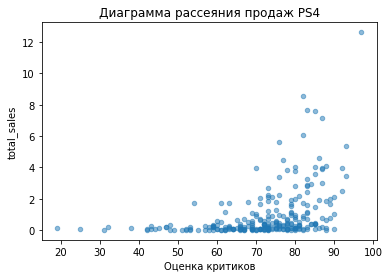

In [74]:
# построим диаграмму рассеяния (total_sales - critic_score)
ps4_platform.plot(x='critic_score', y='total_sales', kind='scatter', alpha=0.5)
plt.title('Диаграмма рассеяния продаж PS4')
plt.xlabel('Оценка критиков')
plt.ylabel('total_sales');

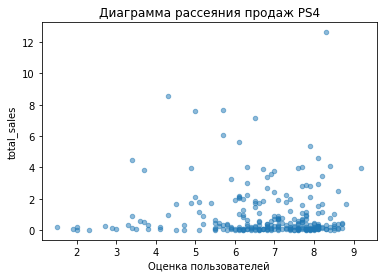

In [75]:
# построим диаграмму рассеяния (total_sales - user_score)
ps4_platform.plot(x='user_score', y='total_sales', kind='scatter', alpha=0.5)
plt.title('Диаграмма рассеяния продаж PS4')
plt.xlabel('Оценка пользователей')
plt.ylabel('total_sales');

In [76]:
# рассчитаем коэф-ты корреляции
correlation_coefficient = ps4_platform['total_sales'].corr(ps4_platform['critic_score'])
print('Коэффициент корреляции между продажами и оценками критиков:', correlation_coefficient)
correlation_coefficient = ps4_platform['total_sales'].corr(ps4_platform['user_score'])
print('Коэффициент корреляции между продажами и оценками пользователей:', correlation_coefficient)

Коэффициент корреляции между продажами и оценками критиков: 0.406567902061781
Коэффициент корреляции между продажами и оценками пользователей: -0.031957110204556424


На диаграмме рассеяния прослеживается определенная зависимость продаж от оценок критиков. Коэффициент корреляции: 0.4. Зависимость продаж от оценок пользователей на графике не очевидна, коэффицент корреляции -0.03, что говорит об отсутствии зависимости продаж от оценок пользователей. Проверим какие зависимости покажут другие платформы.

#### Корреляция для Xbox One

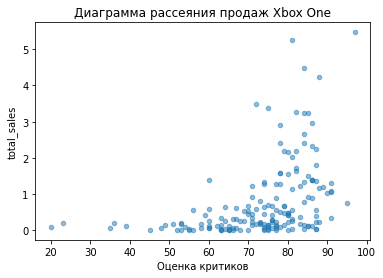

In [77]:
# построим диаграмму рассеяния (total_sales - critic_score)
xbox_one_platform.plot(x='critic_score', y='total_sales', kind='scatter', alpha=0.5)
plt.title('Диаграмма рассеяния продаж Xbox One')
plt.xlabel('Оценка критиков')
plt.ylabel('total_sales');

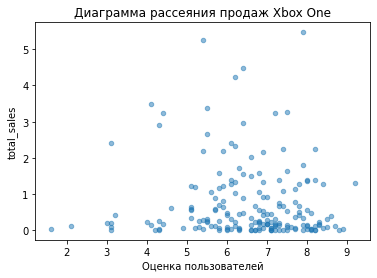

In [78]:
# построим диаграмму рассеяния (total_sales - user_score)
xbox_one_platform.plot(x='user_score', y='total_sales', kind='scatter', alpha=0.5)
plt.title('Диаграмма рассеяния продаж Xbox One')
plt.xlabel('Оценка пользователей')
plt.ylabel('total_sales');

In [79]:
# рассчитаем коэф-ты корреляции
correlation_coefficient = xbox_one_platform['total_sales'].corr(xbox_one_platform['critic_score'])
print('Коэффициент корреляции между продажами и оценками критиков:', correlation_coefficient)
correlation_coefficient = xbox_one_platform['total_sales'].corr(xbox_one_platform['user_score'])
print('Коэффициент корреляции между продажами и оценками пользователей:', correlation_coefficient)

Коэффициент корреляции между продажами и оценками критиков: 0.41699832800840175
Коэффициент корреляции между продажами и оценками пользователей: -0.06892505328279412


Корреляция для Xbox One практически идентична PS4.

#### Корреляция для PC

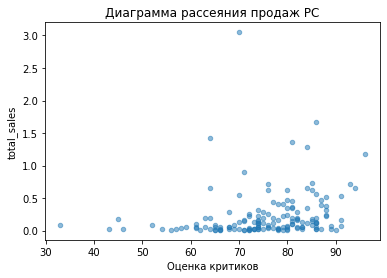

In [80]:
# построим диаграмму рассеяния (total_sales - critic_score)
pc_platform.plot(x='critic_score', y='total_sales', kind='scatter', alpha=0.5)
plt.title('Диаграмма рассеяния продаж PC')
plt.xlabel('Оценка критиков')
plt.ylabel('total_sales');

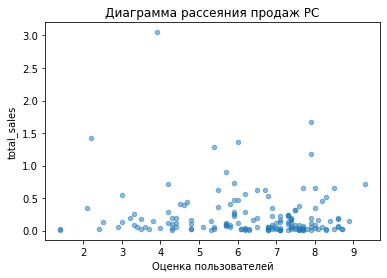

In [81]:
# построим диаграмму рассеяния (total_sales - user_score)
pc_platform.plot(x='user_score', y='total_sales', kind='scatter', alpha=0.5)
plt.title('Диаграмма рассеяния продаж PC')
plt.xlabel('Оценка пользователей')
plt.ylabel('total_sales');

In [82]:
# рассчитаем коэф-ты корреляции
correlation_coefficient = pc_platform['total_sales'].corr(pc_platform['critic_score'])
print('Коэффициент корреляции между продажами и оценками критиков:', correlation_coefficient)
correlation_coefficient = pc_platform['total_sales'].corr(pc_platform['user_score'])
print('Коэффициент корреляции между продажами и оценками пользователей:', correlation_coefficient)

Коэффициент корреляции между продажами и оценками критиков: 0.19603028294369382
Коэффициент корреляции между продажами и оценками пользователей: -0.09384186952476739


Корреляция между продажами и оценками критиков и пользователей для игр на PC и игр на приставках немного отличается:

- коэффициент корреляции "продажи-оценка критиков" для PC 0.19, в то время как на приставках он 0.4 - зависимость от мнения критиков уже меньше;

- коэффициент корреляции "продажи-оценка пользователей" для PC -0.09, на приставках он -0.03 (-0.06) - зависимость по-прежнему отрицательная во всех случаях; 

Таким образом можно сделать вывод, что оценка критиков влияет на продажи в той или иной степени, а вот оценка пользователей не влияет на продажи.

### Распределение игр по жанрам

Посмотрим на общее распределение игр по жанрам. Выделим самые прибыльные жанры и жанры с низкими продажами.

In [83]:
games_grouped = df.groupby(['genre']).agg({'total_sales' : 'sum', 'name' : 'count'}).sort_values('total_sales', ascending=False)
games_grouped.rename(columns={'name': 'count_of_games'}, inplace=True)
games_grouped['ratio_sales_to_total'] = round((games_grouped['total_sales'] * 100) / games_grouped['total_sales'].sum(), 2)
games_grouped['ratio_count_to_total'] = round((games_grouped['count_of_games'] * 100) / games_grouped['count_of_games'].sum(), 2)
games_grouped

,total_sales,count_of_games,ratio_sales_to_total,ratio_count_to_total
genre,,,,
action,321.87,766,29.51,34.30
shooter,232.98,187,21.36,8.37
sports,150.65,214,13.81,9.58
role-playing,145.89,292,13.38,13.08
misc,62.82,155,5.76,6.94
platform,42.63,74,3.91,3.31
racing,39.89,85,3.66,3.81
fighting,35.31,80,3.24,3.58
adventure,23.64,245,2.17,10.97


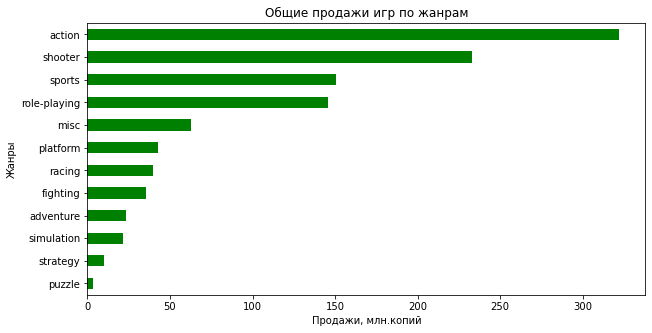

In [84]:
games_grouped.total_sales.sort_values().plot(kind='barh', color='g', figsize=(10,5))
plt.title('Общие продажи игр по жанрам')
plt.xlabel('Продажи, млн.копий')
plt.ylabel('Жанры')
plt.show();

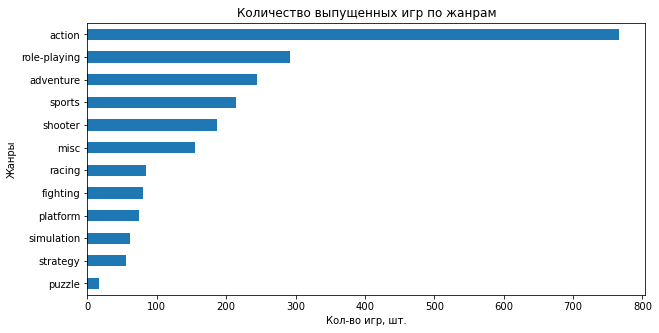

In [85]:
games_grouped.count_of_games.sort_values().plot(kind='barh', figsize=(10,5))
plt.title('Количество выпущенных игр по жанрам')
plt.xlabel('Кол-во игр, шт.')
plt.ylabel('Жанры')
plt.show();

Самые продаваемые жанры игр - это action (321.87 млн.шт.), shooter (232.98), sports (150.65) и role-playing (145.89). Доля жанра action в суммарных продажах почти треть - 29.51%. Самые низкие продажи приходятся на жанры simulation, strategy и puzzle.

Самое большое количество игр выпущено в жанре action: 766 игр. На втором месте по количеству выпущенных игр идет жанр role-playing - 292 игры. Игры в жанре adventure занимают третье место по количеству - 245 шт., при этом по суммарным продажам этот жанр занимает только 9 место с результатом 23.64 млн.копий.

**Посмотрим на медианные данные total_sales в разрезе жанров.**

In [86]:
games_grouped = df.groupby(['genre']).agg({'total_sales' : 'median'}).sort_values('total_sales', ascending=False)
games_grouped

,total_sales
genre,
shooter,0.450
sports,0.240
platform,0.225
role-playing,0.125
fighting,0.125
racing,0.120
action,0.110
simulation,0.100
misc,0.100


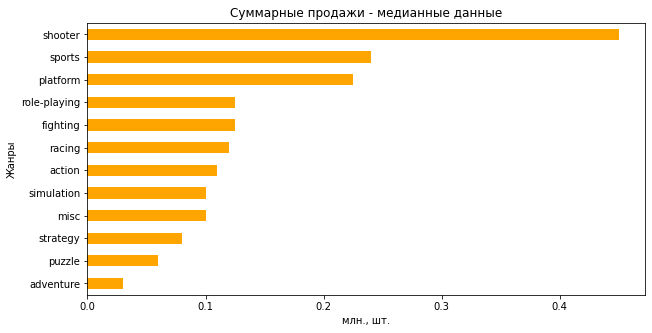

In [87]:
games_grouped.total_sales.sort_values().plot(kind='barh', color='orange', figsize=(10,5))
plt.title('Суммарные продажи - медианные данные')
plt.xlabel('млн., шт.')
plt.ylabel('Жанры')
plt.show();

Если учитывать данные продаж по медиане, без учета выбросов (в нашем случае это игры-хиты), то рейтинг продаваемых жанров отличается от рейтинга суммарного total_sales. Тройка самых продаваемых жанров выглядит следующим образом: На первом месте находится жанр shooter (0.450 млн.шт.), на втором месте - sports (0.240 млн.шт.), на третьем месте - platform (0.225 млн.шт.). Лидер по суммарным продажам - жанр action находится только на седьмой позиции (0.110 млн.шт.), на  четвертом месте role-playing - 0.125 млн.шт., на пятом месте жанр fighting (0.125 млн.шт.).

Таким образом, можно сделать вывод, что за счет выбросов (игры-бестселлеры) на первом месте по суммарным продажам оказался жанр action, в то время как без учета аномалий на первом месте находится жанр shooter.

## Составление портрета пользователя каждого региона

### Самые популярные платформы (топ-5)

Определите для пользователя каждого региона (NA, EU, JP):

•	Самые популярные платформы (топ-5). Опишите различия в долях продаж.

•	Самые популярные жанры (топ-5). Поясните разницу.

•	Влияет ли рейтинг ESRB на продажи в отдельном регионе?

Посмотрим на самые популярные платформы по регионам:

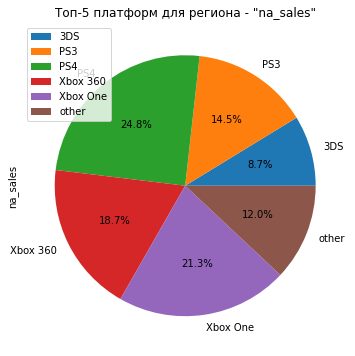

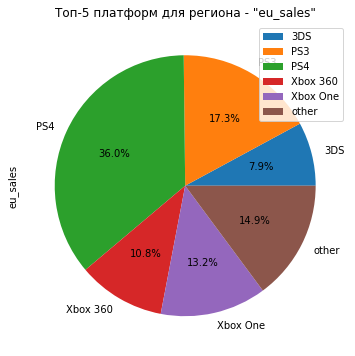

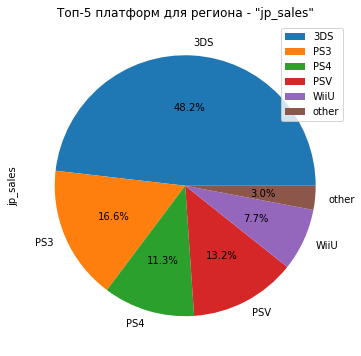

In [88]:
regions = ['na_sales', 'eu_sales', 'jp_sales']
for region in regions:
    region_platforms = df.groupby('platform').agg({region: 'sum'}).sort_values(by=region, ascending=False)
    region_top_platforms = region_platforms.head()
    region_platforms = region_platforms.reset_index()
    region_platforms['platform'] = region_platforms['platform'].where(
        region_platforms['platform'].isin(region_top_platforms. index), 'other')
    region_platforms.groupby('platform').agg({region: 'sum'}).plot(
        kind='pie', y=region, autopct='%1.1f%%', figsize=(8,6))
    plt.title('Топ-5 платформ для региона - "{}"'.format(region))
    plt.show();

Самые популярные платформы по продажам отличаются по регионам: в Северной Америке на первом месте находится платформа PS4 (доля рынка 24.8%), на втором месте Xbox One - 21.3%. Предыдущие версии платформ Xbox 360 и PS3 находятся на третьем и четвертом месте соответственно;

На первом месте в Европе, c большим отрывом от конкурентов, находится PS4 c долей 36%, на втором PS3 - 17.3%. Третье место у Xbox One - 13.2%;

На рынке Японии абсолютно другие лидеры по платформам: первое место занимает приставка 3DS - 48.2%, второе место принадлежит PS3 - 16.6%, третье место у PSV c долей 13.2%.

**Сделаем также визуализацию продаж по производителям платформ.**

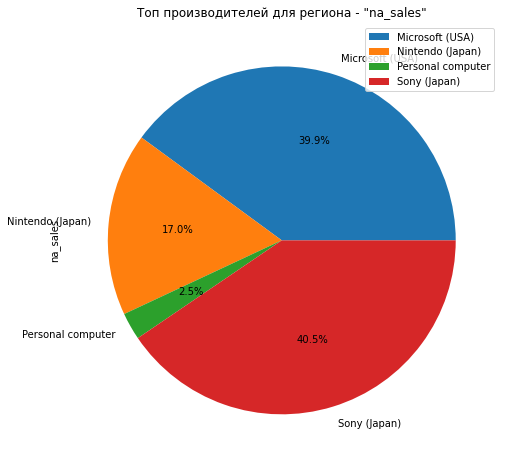

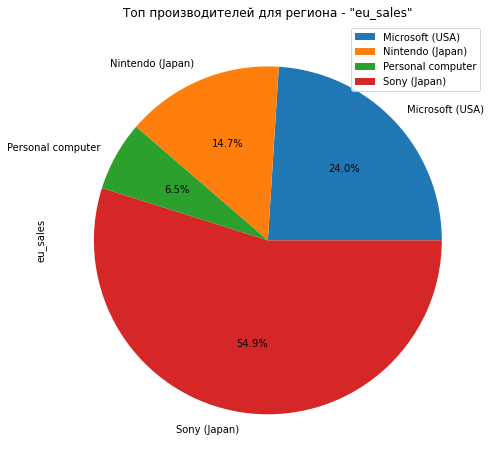

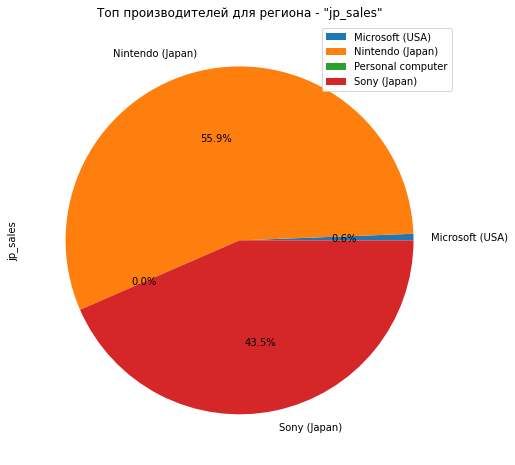

In [89]:
# дополнительно посмотрим на распределение продаж по производителям
for region in regions:
    region_manufacturer = df.groupby('manufacturer').agg({region: 'sum'}).sort_values(by=region, ascending=False)
    region_manufacturer.groupby('manufacturer').agg({region: 'sum'}).plot(kind='pie', y=region, autopct='%1.1f%%', figsize=(10,8))
    plt.title('Топ производителей для региона - "{}"'.format(region))
    plt.show();

Анализ продаж по производителям платформ подтверждает ранее сделанные выводы о различиях по регионам: На рынке Северной Америки лидирует компания Sony (доля 40.5%), доля американского производителя Microsoft почти идентична - 39.9% На рынке Европы лидером также является компания Sony, но ее доля куда более существенна: 54.9% против 24%. В Японии местные компании Nintendo и Sony занимают суммарно долю рынка 99.4%. На первом месте находится компания Nintendo c долей рынка 55.9%, на втором месте находится производитель Sony (43.5% суммарных продаж). Доля Microsoft - 0.6%.

### Самые популярные жанры (топ-5)

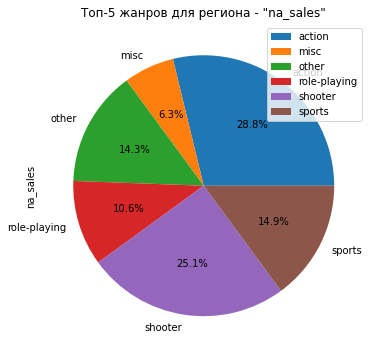

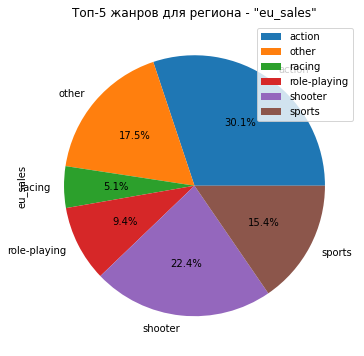

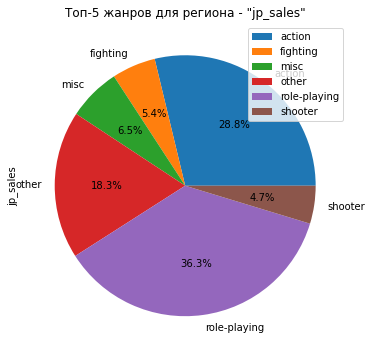

In [90]:
regions = ['na_sales', 'eu_sales', 'jp_sales']
for region in regions:
    region_genres = df.groupby('genre').agg({region: 'sum'}).sort_values(by=region, ascending=False)
    region_top_genres = region_genres.head()
    region_genres = region_genres.reset_index()
    region_genres['genre'] = region_genres['genre'].where(region_genres['genre'].isin(region_top_genres. index), 'other')
    region_genres.groupby('genre').agg({region: 'sum'}).plot(kind='pie', y=region, autopct='%1.1f%%', figsize=(8,6))
    plt.title('Топ-5 жанров для региона - "{}"'.format(region))
    plt.show();

Самые популярные жанры по регионам расположились следующим образом: в Северной Америке на первом месте action (доля 28.8%), на втором shooter - 25.1%, третье место у жанра sports - 14.9%; в Европе результат практически идентичен: на первом месте action (доля 22.4%), на втором shooter - 17.2%, третье место также у жанра sports - 15.4%; рынок Японии снова показывает отличные от Северной Америки и Европы результаты: первое место занимает жанр role-playing, имеющий больше трети доли рынка - 36.3%, на втором action - 28.8%, shooter замыкает Топ-5 жанров в Японии, а жанр sports в него вообще не входит.

### Влияет ли рейтинг ESRB на продажи в отдельном регионе?

In [91]:
ratig_pivot = df.pivot_table(index='rating', values=['na_sales', 'eu_sales', 'jp_sales'])
ratig_pivot

,eu_sales,jp_sales,na_sales
rating,,,
E,0.276026,0.050132,0.261755
E10+,0.169405,0.023373,0.215238
M,0.393821,0.038238,0.447724
T,0.125976,0.061832,0.149520
unknown,0.080768,0.087052,0.091525


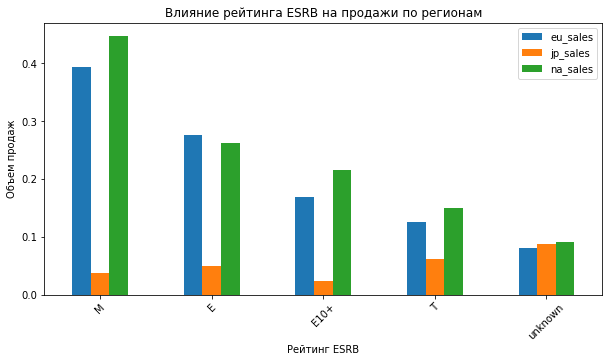

In [92]:
ratig_pivot.sort_values('na_sales', ascending=False).plot(kind='bar', figsize=(10,5))
plt.title('Влияние рейтинга ESRB на продажи по регионам')
plt.xlabel('Рейтинг ESRB')
plt.ylabel('Объем продаж')
plt.xticks(rotation = 45)
plt.show();

В Северной Америке и Европе самые большие продажи игр приходятся на игры с рейтингом М и E (игры для взрослых и каждого), потом идут игры E10+ и Т. Самые  низкие продажи приходятся на игры без рейтинга (неизвестный рейтинг).

В Японии, игры с рейтингом М, Е и Т имеют отличные от других регионов показатели, самые низкие продажи у игр с рейтингом E10+. Максимальные продажи имеют как раз игры без рейтинга (неизвестный рейтинг). Учитывая тот факт, что рейтинг ESRВ присваивается играм в США и Канаде, можно предположить, что игры без рейтинга - это игры выпущенные именно для внутреннего японского рынка, именно в них больше всего играют японцы, и именно поэтому эти игры не получают рейтинг в Северной Америке.

При всем при этом, можно сделать вывод, что возрастной рейтинг не столько влияет на сами продажи, сколько характеризует целевую аудиторию по возрасту там, где этот рейтинг указан.

## Проверка гипотез

### Гипотеза: средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Проверим гипотезы, используя специальный метод для проверки гипотез о равенстве среднего двух генеральных совокупностей по взятым из них выборкам: scipy.stats.ttest_ind.

**Нулевая гипотеза: средние пользовательские рейтинги платформ Xbox One и PC одинаковые.**

Альтернативная гипотеза: пользовательские рейтинги платформ Xbox One и PC отличаются.

Перед проверкой гипотез из проверяемых данных (user_score) необходимо удалить пропуски, т.к. наличие пропусков не позволит рассчитать p-значение.

In [93]:
print('Кол-во строк до удаления:', len(df))
df.dropna(subset=['user_score'], inplace=True)
print('Кол-во строк после удаления:', len(df))

Кол-во строк до удаления: 2233
Кол-во строк после удаления: 1192


In [94]:
platform_sample = df.query('platform in ["Xbox One", "PC"]')
platform_sample.groupby('platform').agg({'user_score': ['count', 'mean', 'std', 'var']}).round(2)

user_score                  
              count  mean   std   var
platform                             
PC              155  6.27  1.74  3.04
Xbox One        182  6.52  1.38  1.91

Наблюдаемые дисперсии отличаются, количество значений в выборке отличается, при использовании теста будем использовать необязательный параметр equal_var = False.

In [95]:
xbox_one = df[df['platform'] == 'Xbox One']['user_score']
pc = df[df['platform'] == 'PC']['user_score']

alpha = 0.01

results = st.ttest_ind(xbox_one, pc, equal_var = False)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.14759594013430463
Не получилось отвергнуть нулевую гипотезу


### Гипотеза: средние пользовательские рейтинги жанров Action и Sports разные

Нулевая гипотеза: средние пользовательские рейтинги жанров Action и Sports одинаковые.

Альтернативная гипотеза: средние пользовательские рейтинги жанров Action и Sports разные.

In [96]:
genre_sample = df.query('genre in ["action", "sports"]')
genre_sample.groupby('genre').agg({'user_score': ['count', 'mean', 'std', 'var']}).round(2)

user_score                  
            count  mean   std   var
genre                              
action        389  6.84  1.33  1.77
sports        160  5.24  1.78  3.18

In [97]:
action_genre = df[df['genre'] == 'action']['user_score']
sports_genre = df[df['genre'] == 'sports']['user_score']

alpha = 0.01

results = st.ttest_ind(action_genre, sports_genre, equal_var = False)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  1.4460039700704315e-20
Отвергаем нулевую гипотезу


По результатам проверки гипотез получаем следующие результаты: средние пользовательские рейтинги платформ Xbox One и PC одинаковые, средние пользовательские рейтинги жанров Action и Sports отличаются.

## Общий вывод

In [98]:
na_sales_total = df['na_sales'].sum().round(2)
print ('Суммарные продажи в регионе "Северная Америка":', na_sales_total)
eu_sales_total = df['eu_sales'].sum().round(2)
print ('Суммарные продажи в регионе "Европа":', eu_sales_total)
jp_sales_total = df['jp_sales'].sum().round(2)
print ('Суммарные продажи в регионе "Япония":', jp_sales_total)
other_sales_total = df['other_sales'].sum().round(2)
print ('Суммарные продажи по остальным регионам:', other_sales_total)
total_sum = na_sales_total + eu_sales_total + jp_sales_total + other_sales_total
print ('Суммарные продажи по всем регионам:', total_sum.round(2))

Суммарные продажи в регионе "Северная Америка": 346.08
Суммарные продажи в регионе "Европа": 310.77
Суммарные продажи в регионе "Япония": 53.86
Суммарные продажи по остальным регионам: 96.03
Суммарные продажи по всем регионам: 806.74


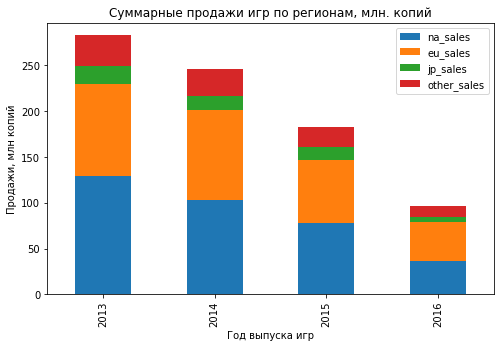

In [99]:
# дополнительно посмотрим на суммарные продажи игр по регионам, выпущенным в конкретный год.
fig, ax = plt.subplots()

(df
 .groupby('year_of_release')[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']]
 .agg('sum')
 .plot(kind='bar',
       stacked=True,
       figsize=(8,5),
       ax=ax))

ax.set_title('Суммарные продажи игр по регионам, млн. копий')
ax.set_xlabel('Год выпуска игр')
ax.set_ylabel('Продажи, млн копий')
plt.show()

По результатам проведенного анализа можно сделать следующие выводы:

Самые актуальные и перспективные платформы на конец 2016 года по суммарным продажам это PS4 и Xbox One. Продажи игр на этих платформах значительно опережают ближайших конкурентов. Жизненный цикл этих платформ начался в 2013 году. При жизненном цикле платформы в 9 лет, активный период использования именно этих платформ не менее 3-х лет.

Самый большой рынок игр приходится на Северную Америку и Европу. В сумме эти 2 рынка дают около 80% продаж от общего количества продаж в мире.

Рынок Европы немного меньше рынка Северной Америки, схож с ним по многим параметрам. При этом есть отличия в распределении популярных платформ, так доля платформы PS4 относительно Xbox One в Европе больше на 11%.

Рынок Японии значительно меньше рынка Европы и рынка Северной Америки. Данный рынок характеризуется значительным отличием вкусов покупателей по платформам, игровым жанрам и возрастным рейтингам присвоенным играм. Рынок характеризуется прежде всего высокой внутренней конкуренцией между Sony и Nintendo, и отсутствием внешних конкурентов. При этом и Sony, и Nintendo представлены в регионах Северная Америка и Европа.

Оценка критиков имеет определенную корреляцию с продажами игр, в то время как оценка пользователей показала отрицательную корреляцию. При распределении рекламного бюджета на продвижение игр стоит опираться в том числе и на игры, имеющие высокие оценки критиков.

Самый популярный жанр игр по суммарным продажам  - это, безусловно, action и его поджанр shooter, также стоит уделить внимание наличию игр в магазине в жанре sports и role-playing. По медианным продажам, в список самых популярных жанров следует добавить жанры misc, platform и strategy.

Самые большие продажи имеют игры с возрастныи рейтингом М, E и E10+ соответственно - это основной возраст целевой аудитории - покупателей игр.

**В целом, при планировании продаж на 2017 год, а также при планировании проведения рекламных компаний по продвижению потенциально популярных продуктов, следует сделать ставку на игры в жанре action и shooter на рынках Северной Америки и Европы, выпущенные на платформах PS4 и Xbox One. При этом в магазине обязательно должны быть представлены игры в жанрах sports, role-playing, misc, platform и strategy. Игры для PC также стоит представить в магазине, данная платформа универсальна, имеет стабильные продажи и не имеет какого-либо жизненного цикла. Целевая клиентская аудитория по играм - это игры для взрослых, игры для всех и всех от 10 лет.**